## Compare Binomial & Multinomial Logistic Regression

> Written by Jess Breda September 2023 post lab meeting

A question that came up (from Carlos) was if the mutli-class model would do better on L/R trials if it was trained on L,R,V. The goal of this notebook is to implement this comparison.

**Initial Steps**:

[X] working with simulated data, figure out the dimensions of the multi-class cost

* follow up questions here if needed

[x] working with simulated data, create a binomial class for fitting (from prev code)

[x] create flexible design matrix for binary/multi

[ ] validate binomial class finds athena/nick like results with base regressors

*  start with single animal, then expand

[ ] see what prev_violation regressor does for binomial model

[ ] figure out how to make train/test split for the models
	
* follow up if diff number of training trials might be an issue

* probably don't want to make this perfect now, but long term good to think about & have this information easily stored
		
[ ] determine what the null model comparison would be (if any?)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pathlib
import sys
from scipy.optimize import minimize

[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from get_rat_data import *

### Dimensions of multi-class cost

In the test eval of the cost function, I want to squash out the third dimension so the model performs better. Eg [1/3 1/3 1/3] should become [1/2 1/2] (or [1/2 1/2 0], not sure yet). Need to focus on figuring out the cost code.

In [114]:
class MultiClassLogisticRegressionComp:
    def __init__(self, sigma=None, method="BFGS", disp=True):
        self.W = None
        self.sigma = sigma
        self.method = method
        self.disp = disp

    def fit(self, X: pd.DataFrame, Y: np.ndarray):
        N, D_w_bias = X.shape
        _, C = Y.shape
        initial_W_flat = np.zeros(D_w_bias * C)

        result = minimize(
            fun=self.cost,
            x0=initial_W_flat,
            args=(X.to_numpy(), Y, self.sigma),
            method=self.method,
            jac=self._gradient,
            options={"disp": self.disp},
        )

        self.W = result.x.reshape(D_w_bias, C)
        return self.W

    def eval(self, X: pd.DataFrame, Y: np.ndarray):
        return self.cost(self.W, X.to_numpy(), Y, sigma=None)

    def cost(self, W, X, Y, sigma, lr_only=False):
        """
        Compute the negative log-likelihood for multi-class
        logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
            for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied
        lr_only : bool (default=False)
            whether to only consider the first two logits (L and R)
            when computing denominator of softmax

        returns
        -------
        - nll : float
            negative log-likelihood
        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W

        # Only consider the first two logits (L and R)
        # when computing denominator of softmax
        if lr_only:
            log_sum_exp_term = self.log_sum_exp_lr(logits)
        else:
            log_sum_exp_term = self.log_sum_exp(logits)

        penalty = (
            (1 / (2 * (sigma**2))) * np.trace(W[1:, :].T @ W[1:, :]) if sigma else 0
        )
        nll = (-np.sum(Y * logits) + np.sum(log_sum_exp_term)) + penalty
        return nll

    def _gradient(self, W, X, Y, sigma):
        """
        Compute the gradient of the negative log-likelihood for
        multi-class logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
        for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        gradient :  np.ndarray, shape (D+1 * C)
            gradient of the negative log-likelihood

        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W
        P = self._stable_softmax(logits)

        if sigma:
            penalty_gradient = W / (sigma**2)
        else:
            penalty_gradient = np.zeros_like(W)

        penalty_gradient[0, :] = 0  # No penalty for bias

        gradient = X.T @ (P - Y) + penalty_gradient
        return gradient.flatten()

    @staticmethod
    def log_sum_exp(logits):
        max_logits = np.max(logits, axis=1, keepdims=True)
        return (
            np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def log_sum_exp_lr(logits):
        max_logits = np.max(
            logits[:, :2], axis=1, keepdims=True
        )  # Only consider the first two logits (L and R)
        return (
            np.log(np.sum(np.exp(logits[:, :2] - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def stable_softmax(logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
        return exp_logits / sum_exp

    def generate_data(self, N, D, C, sigma=None, random_state=None):
        """
        Generate data from a multi-class logistic regression
        model with optional L2 regularization (or MAP).

        params
        ------
        N : int
            number of trials/samples
        D : int
            number of features
        C : int
            number of classes
        sigma : float (default=None)
            standard deviation of true weight matrix, if None
            generated with std of 1
        random_state : int (default=None)
            random seed

        returns
        -------
        w : np.ndarray, shape (D + 1, C)
            true weight matrix
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C)
            one-hot encoded choice labels for C classes
        """

        ## Design Matrix
        X = np.random.normal(size=(N, D))
        X = np.c_[np.ones(N), X]  # add bias column

        ## True Weights
        np.random.seed(random_state)
        if sigma:
            W = np.random.normal(loc=0, scale=sigma, size=(D + 1, C))
        else:
            W = np.random.normal(loc=0, scale=1, size=(D + 1, C))

        ## Choice Labels
        A = X @ W  # logits
        P = self.stable_softmax(A)
        Y = np.array([np.random.multinomial(1, n) for n in P])

        print(f"Generated {N} samples with {D} features and {C} classes")
        print(f"W is {W.shape} \nX is {X.shape} \nY is {Y.shape}")
        print(f"W has mean {np.mean(W):.3f} and std {np.std(W):.3f}")

        return W, X, Y

In [164]:
model = MultiClassLogisticRegressionComp(sigma=1)


N = 100000  # Number of samples
D = 4  # Number of features
C = 3  # Number of classes
sigma = 1.3
W, X, Y = model.generate_data(N, D, C, sigma=sigma, random_state=44)

Generated 100000 samples with 4 features and 3 classes
W is (5, 3) 
X is (100000, 5) 
Y is (100000, 3)
W has mean -0.277 and std 1.434


In [145]:
class BinaryLogisticRegressionComp:
    def __init__(self, sigma=None, method="BFGS", disp=True):
        self.w = None
        self.sigma = sigma
        self.method = method
        self.disp = disp

    def fit(self, X, y):
        N, D_w_bias = X.shape
        initial_w = np.zeros(D_w_bias)

        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        result = minimize(
            fun=self.cost,
            x0=initial_w,
            args=(X, y, self.sigma),
            method=self.method,
            jac=self._gradient,
            options={"disp": self.disp, "maxiter": 10000},
        )

        self.w = result.x
        return result

    def eval(self, X: pd.DataFrame, y: np.ndarray):
        return self.cost(self.w, X.to_numpy(), y, sigma=None)

    def cost(self, w, X, y, sigma):
        """
        Compute the negative log-likelihood for binary
        logistic regression with L2 regularization (or MAP).

        params
        ------
        w : np.ndarray, shape (D + 1, )
            weight vector with bias
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        y : np.ndarray, shape (N, )
            binary encoded choice labels where 0 is left and
            1 is right
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        - nll : float
            negative log-likelihood
        """

        logits = X @ w
        if sigma:
            penalty = (1 / (2 * sigma**2)) * np.sum(w**2)
        else:
            penalty = 0

        nll = -np.mean(y * logits - np.log(1 + np.exp(logits))) + penalty
        return nll

    def _gradient(self, w, X, y, sigma):
        """
        Compute the gradient of the negative log-likelihood for
        binary logistic regression with L2 regularization (or MAP).

        params
        ------
        w : np.ndarray, shape (D + 1, )
            weight vector with bias
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        y : np.ndarray, shape (N, )
            binary encoded choice labels where 0 is left and
            1 is right
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        gradient :  np.ndarray, shape (D + 1, )
            gradient of the negative log-likelihood

        """
        logits = X @ w
        p = 1 - 1 / (1 + np.exp(logits))

        if sigma:
            penalty_gradient = w / sigma**2
            penalty_gradient[0] = 0  # No penalty for bias
        else:
            penalty_gradient = 0

        gradient = (np.dot(X.T, (p - y)) / len(y)) + penalty_gradient
        return gradient

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def generate_data(self, N, D, sigma=None, random_state=None):
        """
        Generate data from a binary logistic regression
        model with optional L2 regularization (or MAP).

        params
        ------
        N : int
            number of trials/samples
        D : int
            number of features
        sigma : float (default=None)
            standard deviation of true weights, if None
            generated with std of 1
        random_state : int (default=None)
            random seed

        returns
        -------
        w : np.ndarray, shape (D + 1, )
            true weight vector
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        y : np.ndarray, shape (N, )
            binary encoded choice labels
        """

        ## Design Matrix
        X = np.random.normal(size=(N, D))
        X = np.c_[np.ones(N), X]  # bias column

        ## True Weights
        np.random.seed(random_state)
        if sigma:
            w = np.random.normal(loc=0, scale=sigma, size=(D + 1))
        else:
            w = np.random.normal(loc=0, scale=1, size=(D + 1))

        ## Choice Labels
        a = X @ w  # logits
        p = self.sigmoid(a)  # probabilities
        y = np.random.binomial(1, p)

        print(f"Generated {N} samples with {D} features")
        print(f"w is {w.shape} \nX is {X.shape} \ny is {y.shape}")
        print(f"w has mean {np.mean(w):.3f} and std {np.std(w):.3f}")

        return w, X, y

In [146]:
bmodel = BinaryLogisticRegressionComp(sigma=20)
w, X, y = bmodel.generate_data(N=100000, D=2, sigma=1, random_state=None)
result = bmodel.fit(X, y)

Generated 100000 samples with 2 features
w is (3,) 
X is (100000, 3) 
y is (100000,)
w has mean -0.287 and std 0.380
Optimization terminated successfully.
         Current function value: 0.625958
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9


In [142]:
def plot_weights(true_W, optimized_W, title="Recovered Weights"):
    fig, ax = plt.subplots(figsize=(6, 4))

    feature_and_bias_labels = np.arange(len(true_W))

    ax.plot(feature_and_bias_labels, true_W, label="true", color="gray", marker="o")
    ax.plot(
        feature_and_bias_labels,
        optimized_W,
        label="optimized",
        color="gray",
        marker="o",
        linestyle="dashed",
    )

    # Set the x-axis tick labels
    _ = ax.set_xticks(feature_and_bias_labels)
    ax.set(xlabel="Feature", ylabel="Weight", title=title)
    ax.legend()

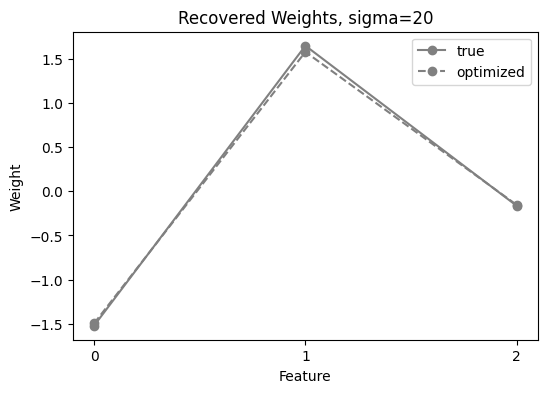

In [143]:
plot_weights(w, result.x, title=f"Recovered Weights, sigma={bmodel.sigma}")

         Current function value: 0.652873
         Iterations: 1
         Function evaluations: 61
         Gradient evaluations: 49


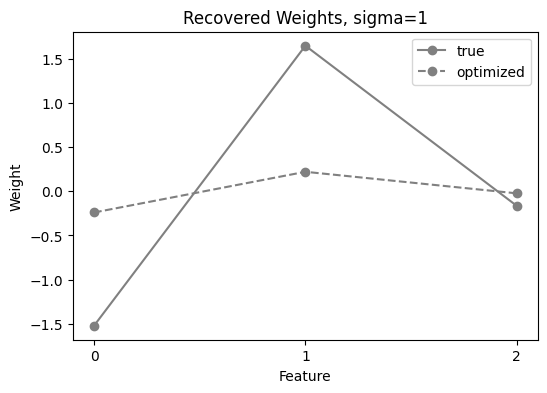

In [144]:
bmodel.sigma = 1
result = bmodel.fit(X, y)

plot_weights(w, result.x, title=f"Recovered Weights, sigma={bmodel.sigma}")

The regularization term effects the ability to recover weights from simulated data. Specifically, a smaller (stronger) sigma gets stuck in a local minima. Made some slides with this summary and plan to continue moving forward

### Recreate Athena/Roy Results

In [150]:
get_rat_viol_data(animal_ids="W065")

returning data for W065


,animal_id,session,trial,s_a,s_b,choice,correct_side,hit,delay,training_stage,violation,n_trial,training_stage_cat
0,W065,1,1,NaN,NaN,0.0,1,0.0,1.0,1,False,508762,1
1,W065,2,1,NaN,NaN,0.0,0,1.0,1.0,1,False,508763,1
2,W065,2,2,NaN,NaN,0.0,0,1.0,1.0,1,False,508764,1
3,W065,2,3,NaN,NaN,0.0,0,1.0,1.0,1,False,508765,1
4,W065,2,4,NaN,NaN,0.0,1,0.0,1.0,1,False,508766,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50100,W065,199,258,76.0,68.0,NaN,1,NaN,6.1,4,True,558862,4
50101,W065,199,259,68.0,76.0,NaN,0,NaN,4.1,4,True,558863,4
50102,W065,199,260,76.0,84.0,NaN,0,NaN,2.1,4,True,558864,4
50103,W065,199,261,68.0,76.0,NaN,0,NaN,6.1,4,True,558865,4


In [193]:
class DesignMatrixGeneratorComp:
    def __init__(self, verbose=True):
        self.verbose = verbose

    @staticmethod
    def normalize_column(col):
        return (col - col.mean()) / col.std()

    def generate_design_matrix(
        self,
        df,
        mode="binary",
        violations="none",
        tau=None,
        return_labels=True,
        drop_session_column=False,
    ):
        """
        Function to generate "base" design matrix given a dataframe
        with violations tracked. In this case "base" means using the
        same regressors as Nick Roy did in Psytrack.

        N = number of trials
        D = number of features

        params
        ------
        df : pd.DataFrame
            dataframe with columns `s_a` `s_b` `session`, `violation`
            `correct_side` and `choice`, likely generated by
            get_rat_viol_data()
        mode : str (default="binary")
            wether to use binary or multi-class logistic regression
        violations : str (default="none")
            whether to include violations as a regressor an if so,
            in what form ("prev", "exp" or "none")
        tau: float (default=None)
            if violations is "exp", tau is the time constant for
            the exponential filter (usually animal specific)
        return_label : bool (default = True)
            whether to return one-hot encoded choice labels
        drop_session_column : bool (default = False)
            whether to drop 'session' column. should be set to
            false if doing session based train/test split
            following design matrix generation

        returns
        -------
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with regressors for s_a, s_b,
            prev sound avg, correct side and choice info,
            normalized to standard normal with bias column added
        Y : np.ndarray, shape (N, 3) if multi-class (N, ) if binary
            when return_labels=True.
        """
        # Initialize
        X = pd.DataFrame()
        stim_cols = ["s_a", "s_b"]
        X["session"] = df.session

        # Masks- if first trial in a session and/or previous trial
        # was a violation, "prev" variables get set to 0
        session_boundaries_mask = df["session"].diff() == 0
        X["prev_violation"] = (
            df["violation"].shift() * session_boundaries_mask
        ).fillna(0)
        prev_violation_mask = X["prev_violation"] == 0

        # # Violation Exp Filter
        if mode == "multi":
            if violations == "exp":
                self.exp_filter = ExpFilter(
                    tau=tau, verbose=self.verbose, column="prev_violation"
                )
                self.exp_filter.apply_filter_to_dataframe(X)
                X.drop(columns=["prev_violation"], inplace=True)
            elif violations == "none":
                X.drop(columns=["prev_violation"], inplace=True)

        # Stimuli (s_a, s_b) get normalized
        for col in stim_cols:
            X[stim_cols] = self.normalize_column(df[stim_cols])

        # Average previous stimulus (s_a, s_b) loudness
        X["prev_sound_avg"] = df[stim_cols].shift().mean(axis=1)
        X["prev_sound_avg"] = self.normalize_column(X["prev_sound_avg"])
        X["prev_sound_avg"] *= session_boundaries_mask * prev_violation_mask

        # Prev correct side (L, R) (0, 1) -> (-1, 1),
        X["prev_correct"] = (
            df.correct_side.replace({0: -1}).astype(int).shift()
            * session_boundaries_mask
            * prev_violation_mask
        )

        # prev choice regressors (L, R, V) (0, 1, Nan) -> (-1, 1, 0),
        X["prev_choice"] = (
            df.choice.replace({0: -1}).fillna(0).astype(int).shift()
            * session_boundaries_mask
        )

        # if binary, drop the violation trials
        if mode == "binary":
            X = X[df["violation"] != 1].reset_index(drop=True)
            X.drop(columns=["prev_violation"], inplace=True)

        X.fillna(0, inplace=True)  # remove nan from shift()
        X.insert(0, "bias", 1)  # add bias column

        if drop_session_column:
            X.drop(columns=["session"], inplace=True)

        if return_labels:
            if mode == "binary":
                # make choice vector L -> -1, R -> 1, drop nans (violations) to match X
                Y = (
                    df["choice"]
                    .dropna()
                    .replace({0: -1})
                    .dropna()
                    .astype(int)
                    .to_numpy()
                )
            elif mode == "multi":
                Y = self.one_hot_encode_labels(df)
            return X, Y
        else:
            return X

    @staticmethod
    def one_hot_encode_labels(df):
        """
        Function to one-hot encode choice labels for each trial as
        left, right or violation (C = 3)

        params
        ------
        df : pd.DataFrame
            dataframe with columns `choice` likely generated by
            get_rat_viol_data()

        returns
        -------
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        """

        Y = pd.get_dummies(df["choice"], "choice", dummy_na=True).to_numpy(copy=True)
        return Y

    def get_train_test_sessions(self, df, test_size, random_state=45):
        """
        This function will return a list of sessions to use for training
        and testing respectively. To apply, see function
        see apply_session_train_test_split()


        Parameters:
        -----------
        df : pd.DataFrame
            dataframe with `sessions` column
        test_size : float
            Proportion of data to use for test set
        """
        unique_sessions = df["session"].unique()
        train_sessions, test_sessions = train_test_split(
            unique_sessions, test_size=test_size, random_state=random_state
        )

        self.train_sessions = train_sessions
        self.test_sessions = test_sessions

    def apply_session_train_test_split(self, X, Y):
        """
        train_sessions = np.array
            sessions for the
        test_values = np.array indices for the test values

        """
        # TODO add in a check to see if self._train_session
        # TODO exists, and if not, call get_train_test_sessions

        # Filter rows based on session values for X
        X_train = X[X["session"].isin(self.train_sessions)].copy()
        X_test = X[X["session"].isin(self.test_sessions)].copy()

        # Filter rows based on session values for Y
        # Assuming the index of Y corresponds to that of X
        Y_train = Y[X["session"].isin(self.train_sessions).values]
        Y_test = Y[X["session"].isin(self.test_sessions).values]

        X_train.drop(columns=["session"], inplace=True)
        X_test.drop(columns=["session"], inplace=True)

        return X_train, X_test, Y_train, Y_test


class ExpFilter:
    def __init__(self, tau, column="violation", len_factor=5, verbose=True):
        self.tau = tau
        self.column = column
        self.len_factor = len_factor
        self.verbose = verbose

    def create_kernel(self):
        """
        create an exp decay kernal with time constant tau and
        kernel length = len factor * tau
        """

        return np.array(
            [np.exp(-i / self.tau) for i in range(self.len_factor * self.tau)]
        )

    def plot_kernel(self):
        kernel = self.create_kernel()
        fig, ax = plt.subplots(figsize=(6, 4))
        plt.plot(kernel)
        plt.title(f"Exponential filter kernel | Tau: {self.tau}")
        plt.xlabel("Trial")
        plt.show()

    def apply_filter_to_session(self, session_df):
        """
        apply kernel to individual sessions for independent
        filtering of column history
        """
        kernel = self.create_kernel()

        # Convolve the kernel with selected column
        convolution_result = np.convolve(session_df[self.column], kernel, mode="full")[
            : len(session_df)
        ]

        session_df[f"{self.column}_exp_{self.tau}"] = convolution_result

        return session_df

    def apply_filter_to_dataframe(self, source_df, output_df=None):
        """
        Function to apply exp kernel to a column given and
        entire dataframe on a session-by-session basis
        """
        if self.tau == 0:
            return

        if output_df is None:
            output_df = source_df

        for session_id, session_data in source_df.groupby("session"):
            filtered_session = self.apply_filter_to_session(session_data.copy())
            output_df.loc[
                output_df["session"] == session_id, f"{self.column}_exp_{self.tau}"
            ] = filtered_session[f"{self.column}_exp_{self.tau}"]

            if self.verbose:
                print(
                    f"Exp filter added for session {session_id} | Column: {self.column}, Tau: {self.tau}"
                )

        # scale column by max to bound between 0 and 1
        output_df[f"{self.column}_exp_{self.tau}"] /= output_df[
            f"{self.column}_exp_{self.tau}"
        ].max()

In [194]:
dmg = DesignMatrixGeneratorComp(verbose=True)

animal_df = get_rat_viol_data(animal_ids="W065")

returning data for W065


In [198]:
dmg.generate_design_matrix(
    animal_df, mode="multi", violations="prev", tau=4, return_labels=False
)

,bias,session,prev_violation,s_a,s_b,prev_sound_avg,prev_correct,prev_choice
0,1,1,0,0.000000,0.000000,0.0,0.0,0.0
1,1,2,0,0.000000,0.000000,0.0,0.0,-0.0
2,1,2,0,0.000000,0.000000,0.0,-1.0,-1.0
3,1,2,0,0.000000,0.000000,0.0,-1.0,-1.0
4,1,2,0,0.000000,0.000000,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...
50100,1,199,1,0.159355,-0.763652,0.0,-0.0,0.0
50101,1,199,1,-0.677573,0.009407,-0.0,0.0,0.0
50102,1,199,1,0.159355,0.782466,-0.0,-0.0,0.0
50103,1,199,1,-0.677573,0.009407,0.0,-0.0,0.0


## Next

make a run function or some outer loop for binary to check on athena's nicks regressors